In [1097]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

## Calculating Wind Veer and Shear

In [1415]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    accounting for the 0-360 degree wraparound.
    
    Parameters:
    dir1, dir2: Wind directions in degrees (0-360)
    
    Returns:
    Difference in degrees (between -180 and 180).
    """
    # Calculate the raw difference
    diff = dir2 - dir1
    
    # Use modulo arithmetic to handle wraparound
    diff = (diff + 180) % 360 - 180
    return diff

def calculate_wind_veer(file_paths, start_date=None, end_date=None):
    """
    Calculate wind veer and wind shear from netCDF files, using Azim for wind direction and qc_Azim for quality control.
    
    Parameters:
        file_paths (list): List of netCDF file paths.
        start_date (datetime): Optional start date as a datetime object.
        end_date (datetime): Optional end date as a datetime object.
    
    Returns:
        tuple: Times (datetime objects), wind veer values, and wind shear values.
    """
    all_times = []
    all_wind_veer = []

    print("Start Date: ", start_date)
    print("End Date: ", end_date)

    # Convert start_date and end_date to UTC (if need be)
    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(file_path)
        
        # Load netCDF file using xarray
        ds = xr.open_dataset(file_path)
        
        # Extract data
        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values  # Quality control variable for wind speed
        azim = ds['Azim'].values  # Wind direction (vector-averaged) in degrees
        qc_azim = ds['qc_Azim'].values  # Quality control variable for wind direction
        
        times = pd.to_datetime(time_var.values, utc=True)  # Convert to datetime
        
        # Filter by date range if specified
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
            azim = azim[valid_idx, :]
            qc_azim = qc_azim[valid_idx, :]

        # Ensure height indices for 40m and 140m are correct
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        # Calculate wind veer (difference in wind direction between 140m and 40m)
        wind_direction_40m = azim[:, idx_40m]  # Wind direction at 40m
        wind_direction_140m = azim[:, idx_140m]  # Wind direction at 140m

        
        # Calculate wind shear (difference in wind speed with height, normalized over vertical distance)
        height_diff = height_var[idx_140m] - height_var[idx_40m]  # Vertical distance between 40m and 140m
        wind_speed_40m = vhm[:, idx_40m]  # Wind speed at 40m
        wind_speed_140m = vhm[:, idx_140m]  # Wind speed at 140m        

        # Compute wind veer as the shortest rotational path between the two heights
        difference = wind_direction_difference(wind_direction_40m, wind_direction_140m)
        
        wind_veer =  difference / height_diff
        
        # Mask invalid values using qc_Vhm (wind speed) and qc_Azim (wind direction)
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0)
        times = times[valid_mask]
        wind_veer = wind_veer[valid_mask]

        # Append data to lists
        all_times.extend(times)
        all_wind_veer.extend(wind_veer)



    return all_times, all_wind_veer

## Wind Shear using Power Law

In [1356]:
import numpy as np
import pandas as pd
import xarray as xr

def calculate_power_law_exponent(v1, v2, z1, z2):
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")
    return np.log(v2 / v1) / np.log(z2 / z1)

def calculate_wind_shear_with_alpha(file_paths, start_date=None, end_date=None):
    all_times = []
    all_alpha = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(f"Processing file: {file_path}")
        ds = xr.open_dataset(file_path)

        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values
        
        #print(f"Height variable: {height_var}")
        #print(f"Vhm shape: {vhm.shape}, QC shape: {qc_vhm.shape}")

        times = pd.to_datetime(time_var.values, utc=True)
        
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            #print(f"Valid time indices: {np.sum(valid_idx)}")
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
        
        idx_40m = np.where(height_var == 40)[0]
        idx_140m = np.where(height_var == 140)[0]
        
        if len(idx_40m) == 0 or len(idx_140m) == 0:
            print(f"Available heights: {height_var}")
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        idx_40m, idx_140m = idx_40m[0], idx_140m[0]
        #print(f"Indices for 40m: {idx_40m}, 140m: {idx_140m}")

        wind_speed_40m = vhm[:, idx_40m]
        wind_speed_140m = vhm[:, idx_140m]
        
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0)
        #print(f"Valid mask has {np.sum(valid_mask)} valid entries")
        
        times = times[valid_mask]
        wind_speed_40m = wind_speed_40m[valid_mask]
        wind_speed_140m = wind_speed_140m[valid_mask]

        if len(times) == 0:
            #print("on file: ", file_path)
            #print("No valid data points after filtering by QC.")
            continue
        
        try:
            alpha = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
        except ValueError as e:
            print(f"Error in alpha calculation: {e}")
            continue

        #print(f"Calculated alpha values: {alpha[:5]} (showing first 5)")
        all_times.extend(times)
        all_alpha.extend(alpha)

    return all_times, all_alpha


### Wind Veer Plotting 

In [1185]:
def plot_wind_veer(times, wind_veer):
    """
    Plot wind veer over time.
    
    Parameters:
        times (list): List of datetime objects.
        wind_veer (list): List of wind veer values.
    """
    # Debugging: Check the data before plotting
    if len(times) == 0 or len(wind_veer) == 0:
        print("Error: No data to plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(times, wind_veer, label="Wind Veer (140m - 40m)", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Wind Veer (m/s)")
    plt.title("Wind Veer Over Time")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

## File Collection

In [1394]:
import os
from datetime import datetime

def filter_files_by_date(directory, start_date, end_date):
    """
    Filters file paths in a directory that match a date range and sorts them by date.

    Parameters:
        directory (str): Directory containing the files.
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.

    Returns:
        list: List of file paths within the date range, sorted by date.
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        #below is for site A2
        if 'sa2.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        #below is for site C1A
        #if 'sc1.lidar.z03.c0.'in file_name and file_name.endswith('.sta.nc'):
            try:
                # Extract the date part from the filename
                date_str = file_name.split('.')[4].strip()  # Strip any leading/trailing spaces
                
                # Convert to datetime object
                file_date = datetime.strptime(date_str, '%Y%m%d')
                
                # Check if the file date is within the range
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))
                    
            except (IndexError, ValueError) as e:
                continue
    
    # Sort the files by the date (first element in the tuple)
    filtered_files.sort(key=lambda x: x[0])
    
    # Return the list of file paths sorted by date
    return [file_path for _, file_path in filtered_files]

# Usage for Site A2
directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteA2'
#Usage for Site C1a
#directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'

start_date = '20221111'  # Replace with any start date
end_date = '20231106'    # Replace with any end date

matching_files = filter_files_by_date(directory, start_date, end_date)
#print("Matching files:")
#for file_path in matching_files:
#    print(file_path)

### Set Times Below - run each time choose new time frame

In [1422]:
start_date = datetime(2022, 11, 11)
end_date = datetime(2023, 11, 6)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)


Start Date:  2022-11-11 00:00:00
End Date:  2023-11-06 00:00:00


## Annual C1A

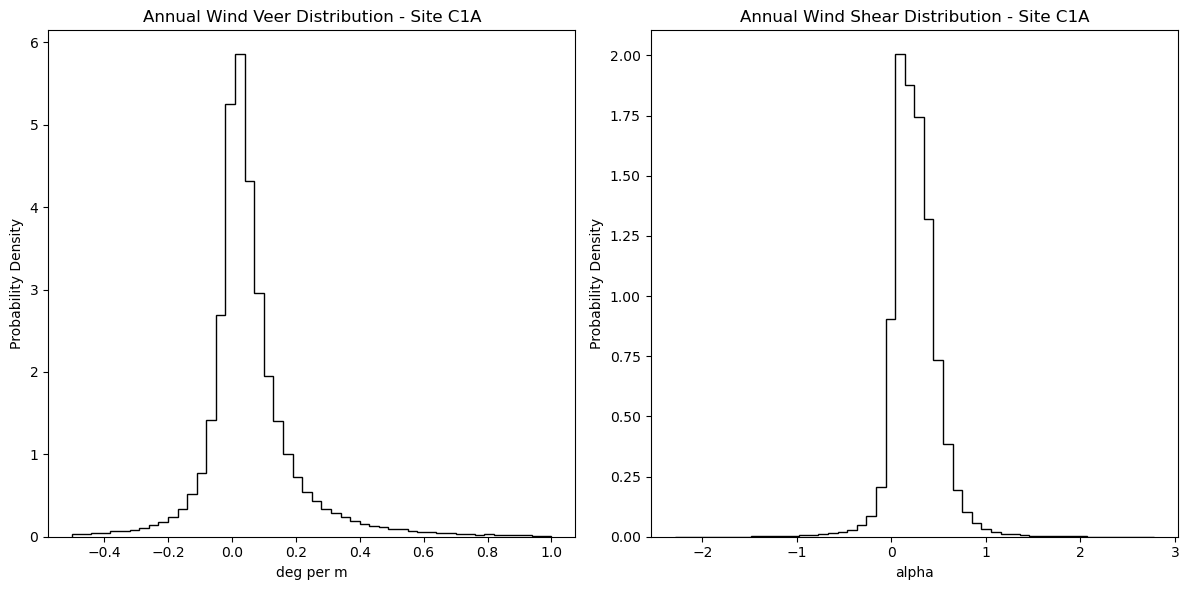

In [1346]:

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', histtype='step',range=[-0.5,1.0], density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Veer Distribution - Site C1A')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear, bins=50, edgecolor='black', histtype='step', density=True)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Shear Distribution - Site C1A')

# Show the plot
plt.tight_layout()
plt.show()


## Annual A2

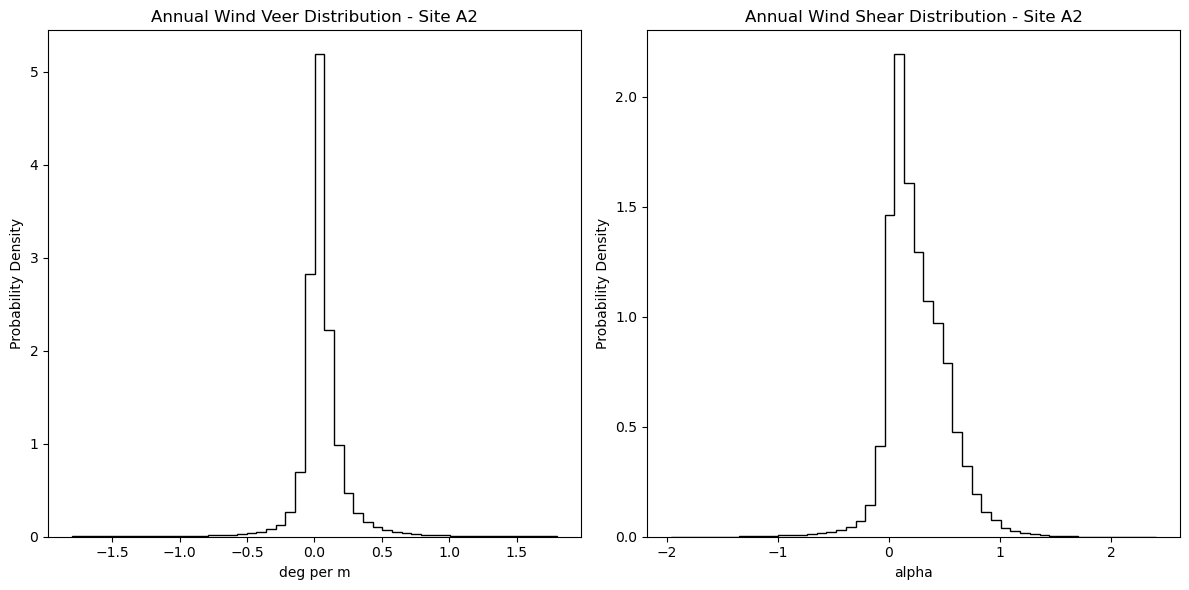

In [1411]:

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', histtype='step', density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Veer Distribution - Site A2')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear, bins=50, edgecolor='black', histtype='step', density=True)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Shear Distribution - Site A2')

# Show the plot
plt.tight_layout()
plt.show()


In [1384]:
def plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date):
    """
    Plots daily average wind veer and wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC).
    """
    # Check if the lengths of times, wind_veer, and wind_shear match
    if not (len(times) == len(wind_veer) == len(wind_shear)):
        raise ValueError("The lengths of 'times', 'wind_veer', and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        #print("Localizing times to UTC...")
        times = times.tz_localize('UTC')

    #print(f"Converting start_date ({start_date}) and end_date ({end_date}) to datetime...")
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    #print("Creating DataFrame with time, wind_veer, and wind_shear...")
    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    #print("Creating a complete index for all times of day...")
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping averages together
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
    daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
    #print("Daily average wind veer (sample):\n", daily_avg_veer.head())
    #print("Daily average wind shear (sample):\n", daily_avg_shear.head())

    fig, ax1 = plt.subplots(figsize=(12, 6))

    veer_line, = ax1.plot(
        daily_avg_veer.index, daily_avg_veer.values, 
        color='black', linestyle='--', label='Wind Veer (deg/m)'
    )
    ax1.set_xlabel('Time of Day')
    ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()
    shear_line, = ax2.plot(
        daily_avg_shear.index, daily_avg_shear.values, 
        color='black', linestyle='-', label='Wind Shear (m/s/m)'
    )
    ax2.set_ylabel('Wind Shear (m/s/m)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    ax1.set_xticks(np.linspace(0, len(all_times) - 1, 24))  # 24 evenly spaced ticks for hours
    ax1.set_xticklabels([all_times[i] for i in np.linspace(0, len(all_times) - 1, 24, dtype=int)], rotation=45)
    
    #below is for Site C1A
    #ax1.set_title(f'Site C1A Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}')

    #below is for Site A2
    ax1.set_title(f'Site A2 Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}')

    # Add legend
    lines = [veer_line, shear_line]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')

    fig.tight_layout()
    plt.show()

# Example usage:
# Ensure that times, wind_veer, and wind_shear have the same length

# Example usage:
#formatted_times = [t.strftime('%Y-%m-%d %H:%M') for t in times]  # times should be a list of datetime objects


## Daily Monthly Averages C1A

C1A DAILY MONTHLY AVERAGES
Note: C1A has more data so includes full Novemeber 2022 and November 2023, A1 does not

 NOVEMEBER 2022
Start Date:  2022-11-01 00:00:00
End Date:  2022-11-30 00:00:00


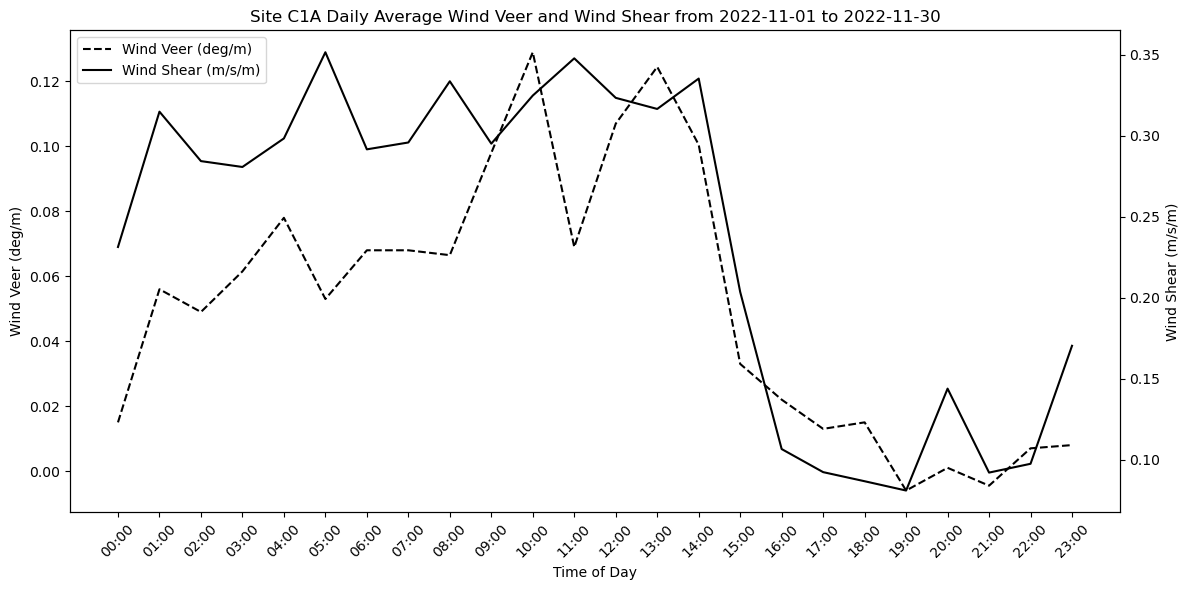


 DECEMBER 2022
Start Date:  2022-12-01 00:00:00
End Date:  2022-12-31 00:00:00


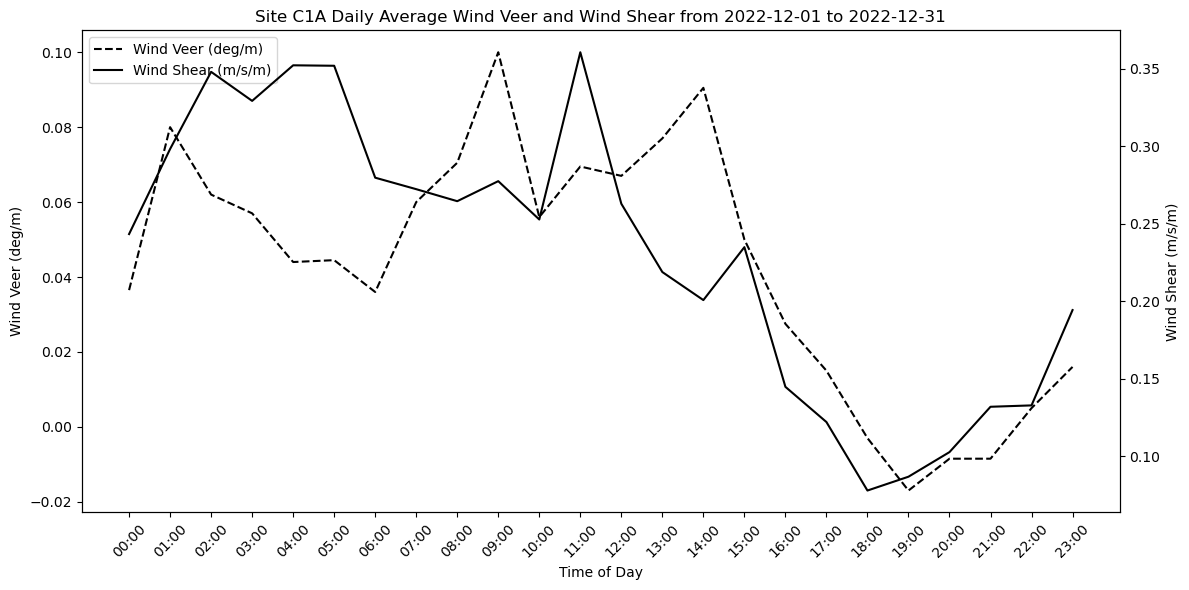


 JANUARY 2023
Start Date:  2023-01-01 00:00:00
End Date:  2023-01-31 00:00:00


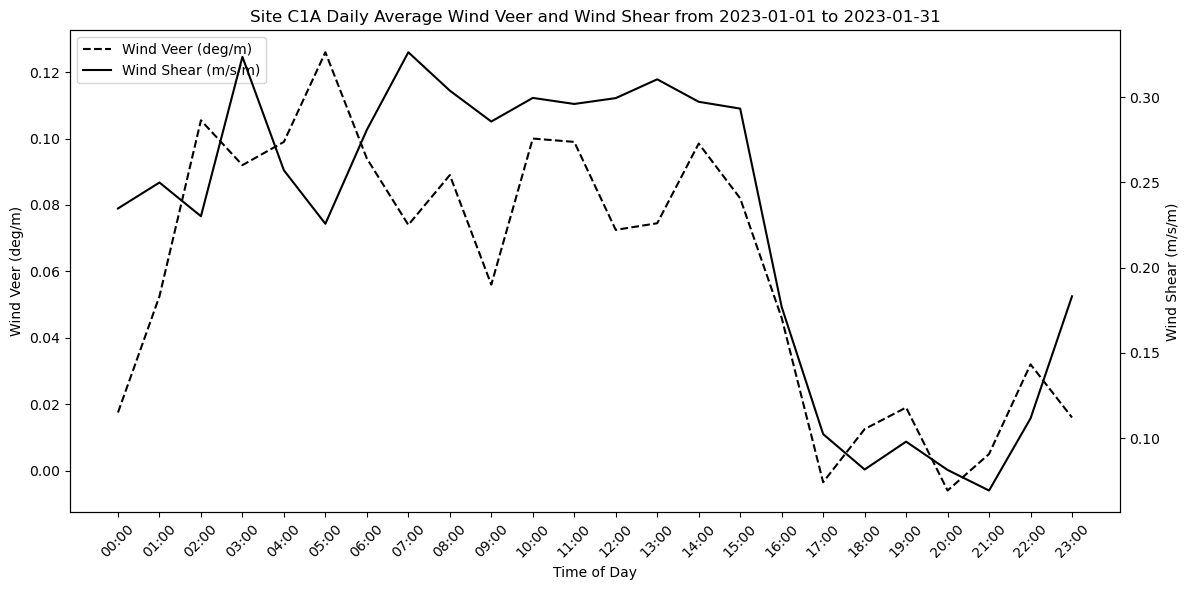


 FEBRUARY 2023
Start Date:  2023-02-01 00:00:00
End Date:  2023-02-28 00:00:00


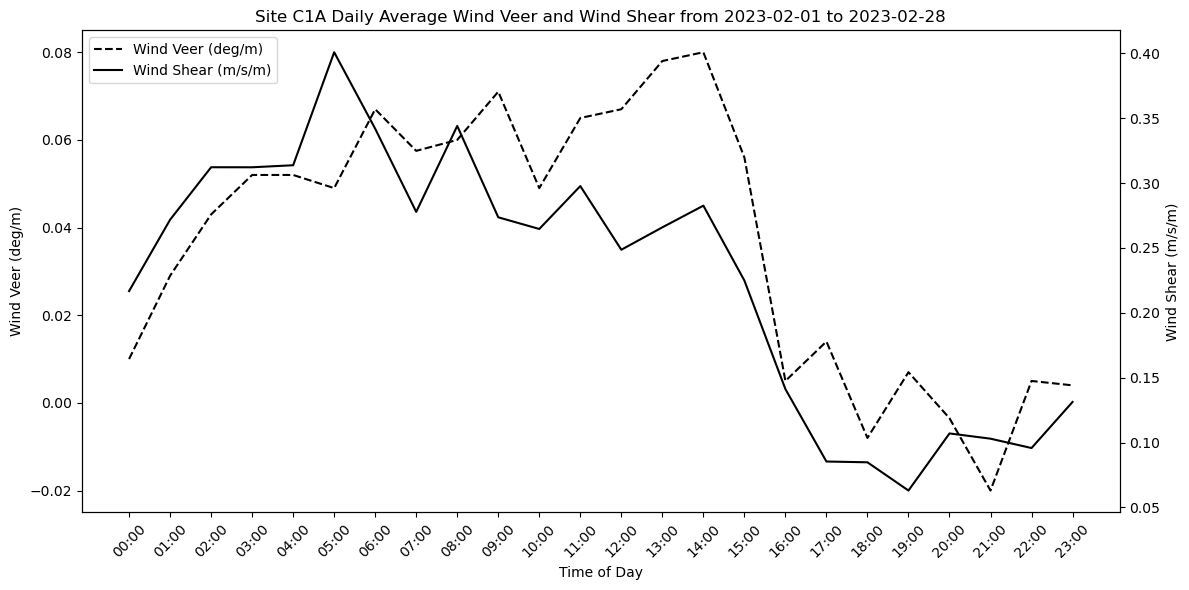


 MARCH 2023
Start Date:  2023-03-01 00:00:00
End Date:  2023-03-31 00:00:00


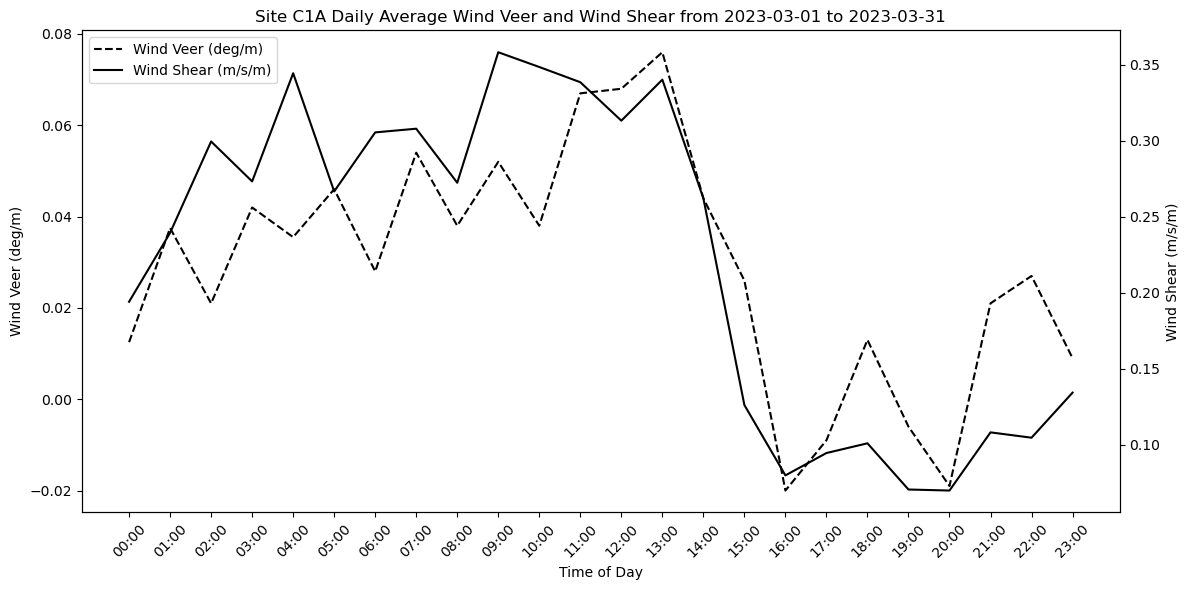


 APRIL 2023
Start Date:  2023-04-01 00:00:00
End Date:  2023-04-30 00:00:00


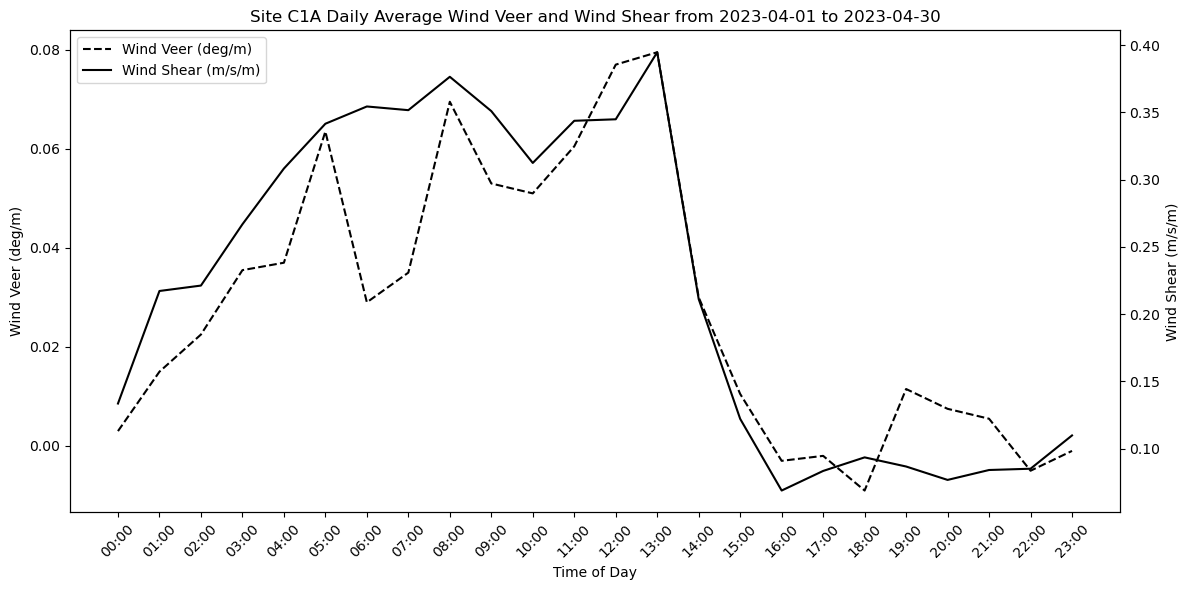


 MAY 2023
Start Date:  2023-05-01 00:00:00
End Date:  2023-05-31 00:00:00


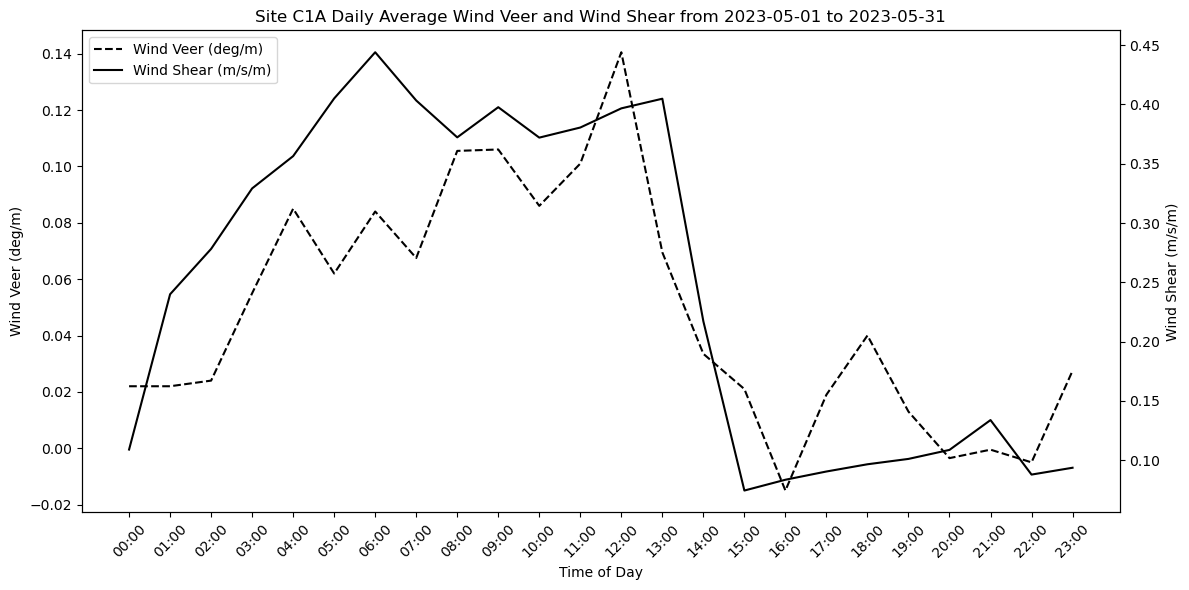


 JUNE 2023
Start Date:  2023-06-01 00:00:00
End Date:  2023-06-30 00:00:00


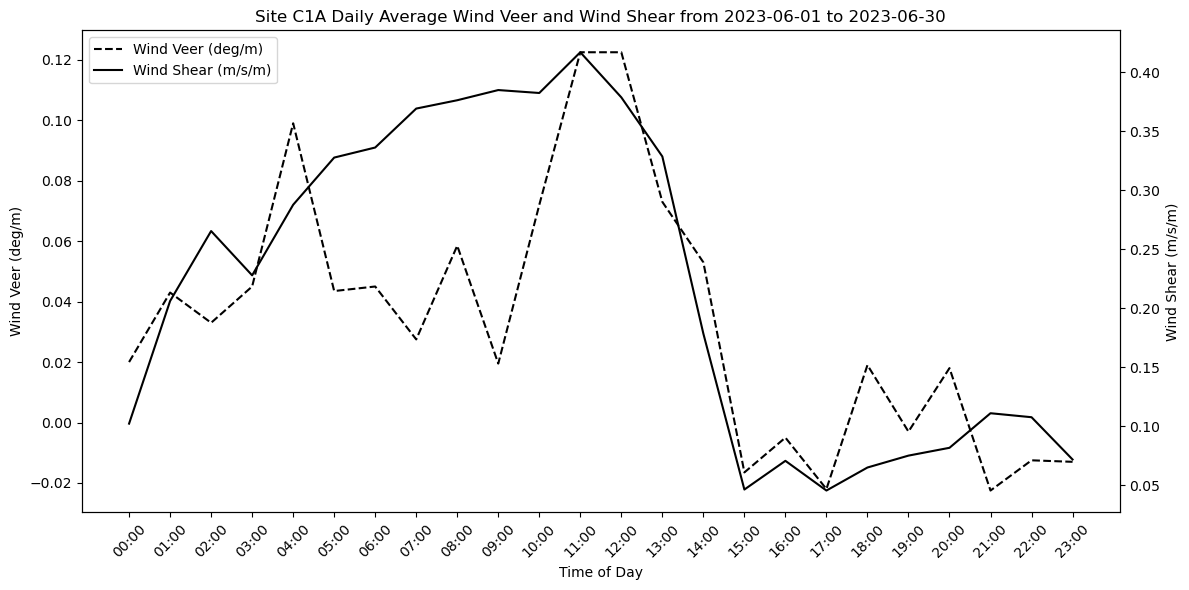


 JULY 2023
Start Date:  2023-07-01 00:00:00
End Date:  2023-07-31 00:00:00


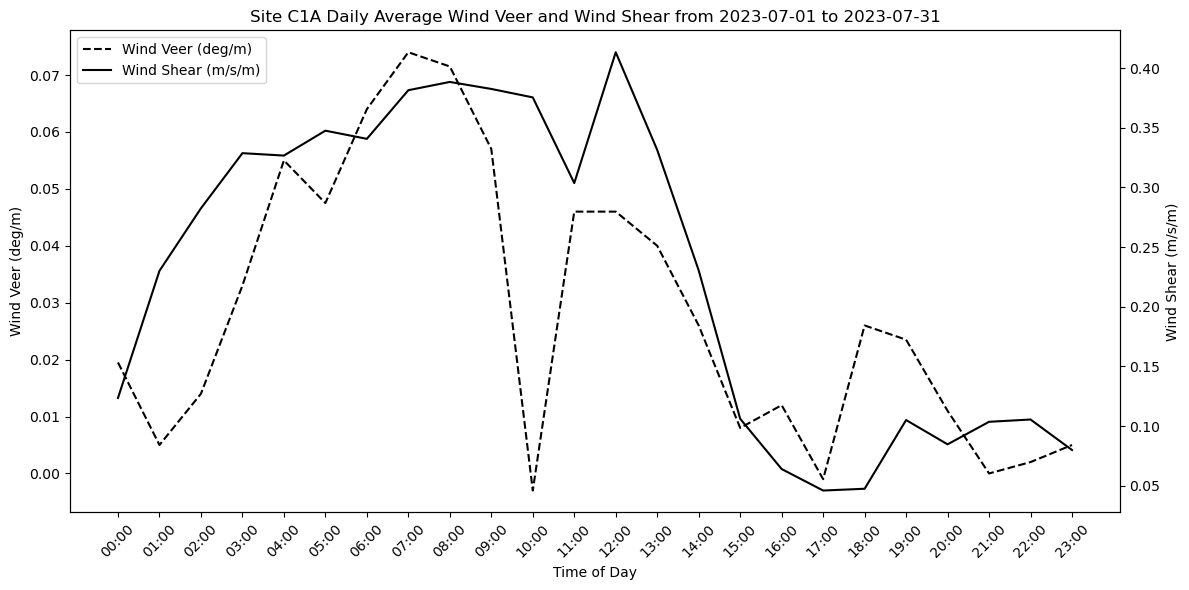


 AUGUST 2023
Start Date:  2023-08-01 00:00:00
End Date:  2023-08-31 00:00:00


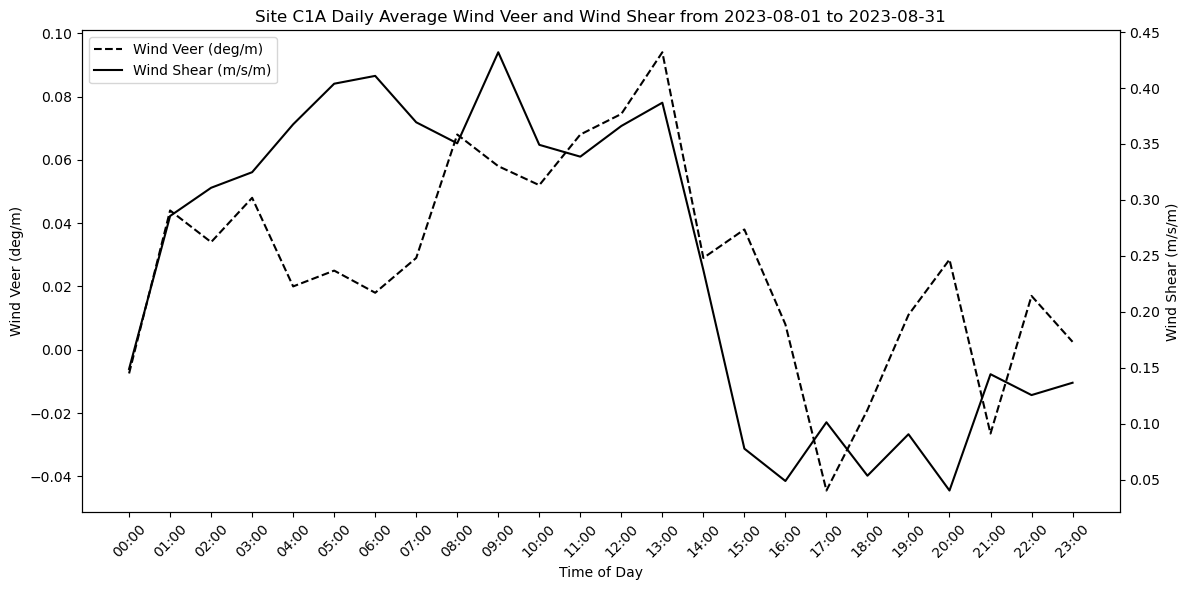


 SEPTEMBER 2023
Start Date:  2023-09-01 00:00:00
End Date:  2023-09-30 00:00:00


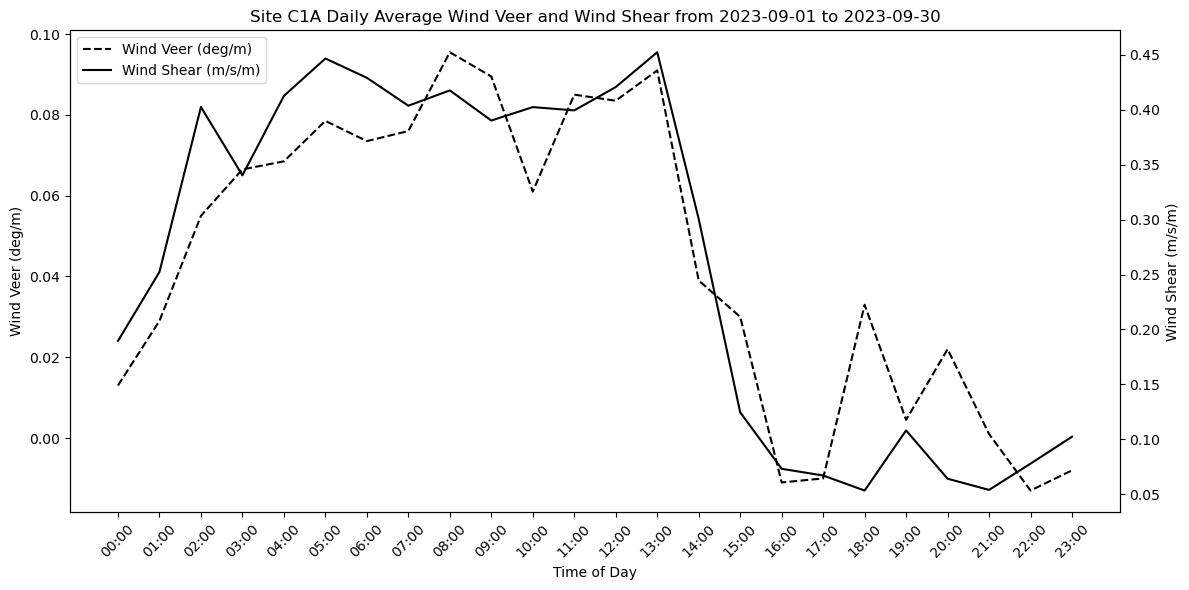


 OCTOBER 2023
Start Date:  2023-10-01 00:00:00
End Date:  2023-10-31 00:00:00


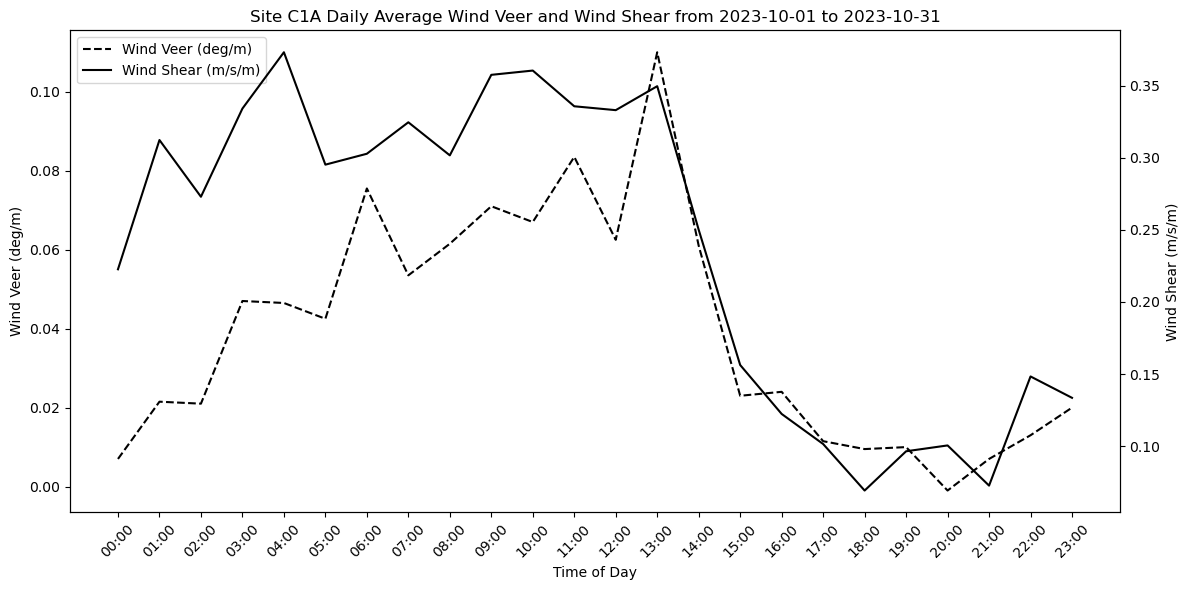


 NOVEMBER 2023
Start Date:  2023-11-01 00:00:00
End Date:  2023-11-30 00:00:00


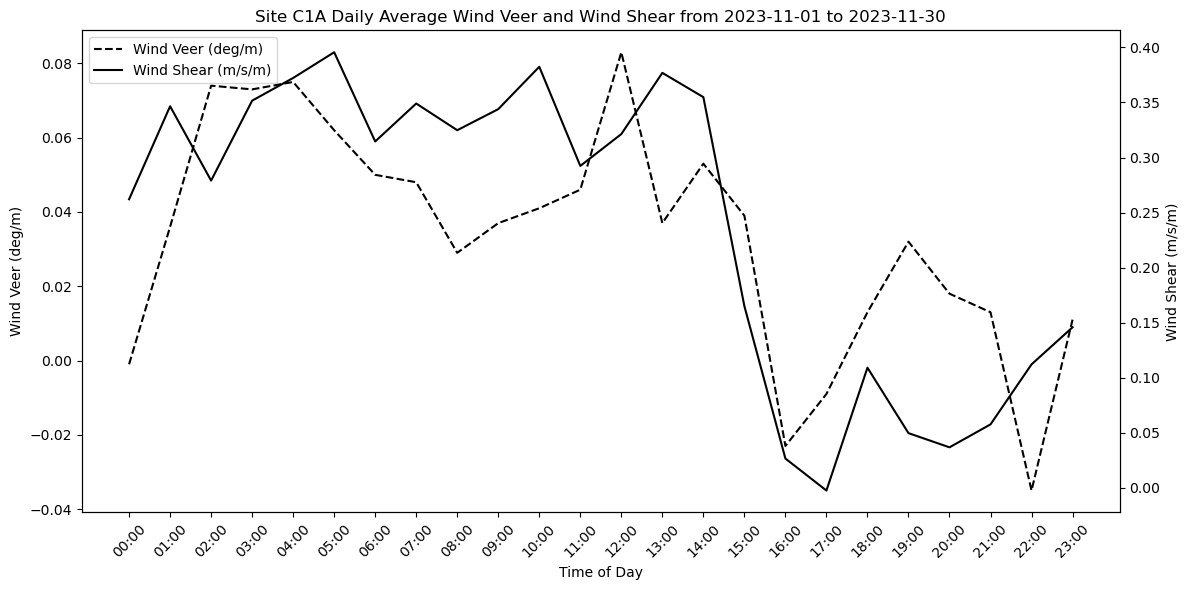

In [1379]:
print("C1A DAILY MONTHLY AVERAGES")
print("Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not")

#for 11-2022
print("\n", "NOVEMEBER 2022")
start_date = datetime(2022, 11, 1)
end_date = datetime(2022, 11, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 12-2022
print("\n", "DECEMBER 2022")
start_date = datetime(2022,12,1)
end_date = datetime(2022, 12, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 01-2023
print("\n", "JANUARY 2023")
start_date = datetime(2023,1,1)
end_date = datetime(2023, 1, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 02-2023
print("\n", "FEBRUARY 2023")
start_date = datetime(2023,2,1)
end_date = datetime(2023, 2, 28)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 03-2023
print("\n", "MARCH 2023")
start_date = datetime(2023,3,1)
end_date = datetime(2023, 3, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 04-2023
print("\n", "APRIL 2023")
start_date = datetime(2023,4,1)
end_date = datetime(2023, 4, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 05-2023
print("\n", "MAY 2023")
start_date = datetime(2023,5,1)
end_date = datetime(2023, 5, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 06-2023
print("\n", "JUNE 2023")
start_date = datetime(2023,6,1)
end_date = datetime(2023, 6, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 07-2023
print("\n", "JULY 2023")
start_date = datetime(2023,7,1)
end_date = datetime(2023, 7, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 08-2023
print("\n", "AUGUST 2023")
start_date = datetime(2023,8,1)
end_date = datetime(2023, 8, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 09-2023
print("\n", "SEPTEMBER 2023")
start_date = datetime(2023,9,1)
end_date = datetime(2023, 9, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 10-2023
print("\n", "OCTOBER 2023")
start_date = datetime(2023,10,1)
end_date = datetime(2023, 10, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 11-2023 (end date is later than A2 - can do full month)
print("\n", "NOVEMBER 2023")
start_date = datetime(2023,11,1)
end_date = datetime(2023, 11, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

## Daily Averages for A2

A2 DAILY MONTHLY AVERAGES
Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not

 NOVEMEBER 2022
Start Date:  2022-11-11 00:00:00
End Date:  2022-11-30 00:00:00


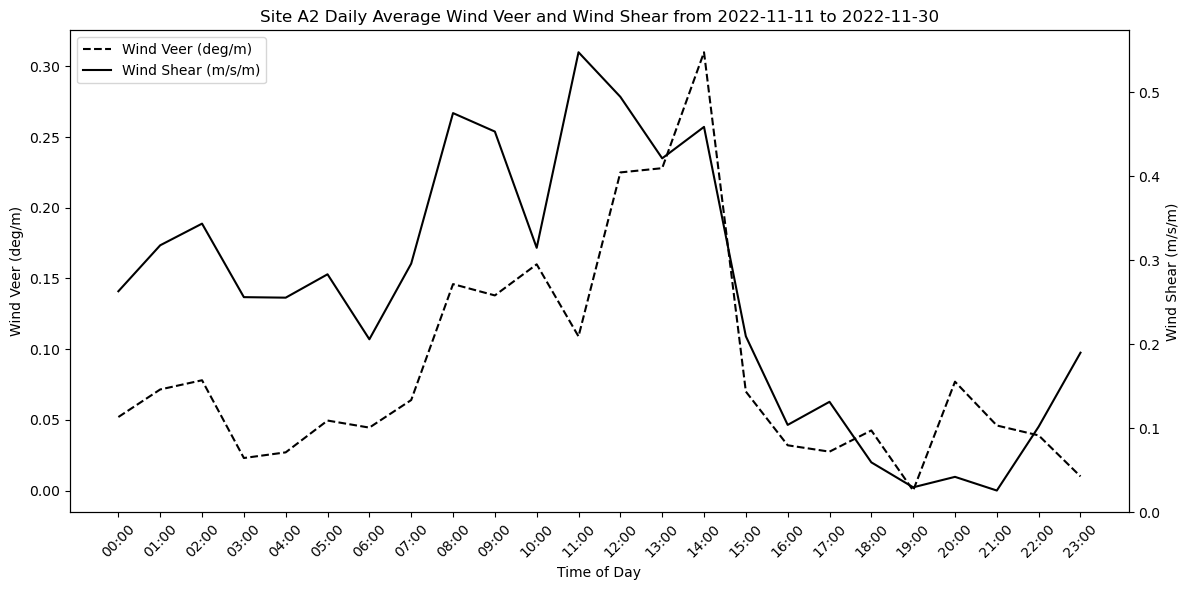


 DECEMBER 2022
Start Date:  2022-12-01 00:00:00
End Date:  2022-12-31 00:00:00


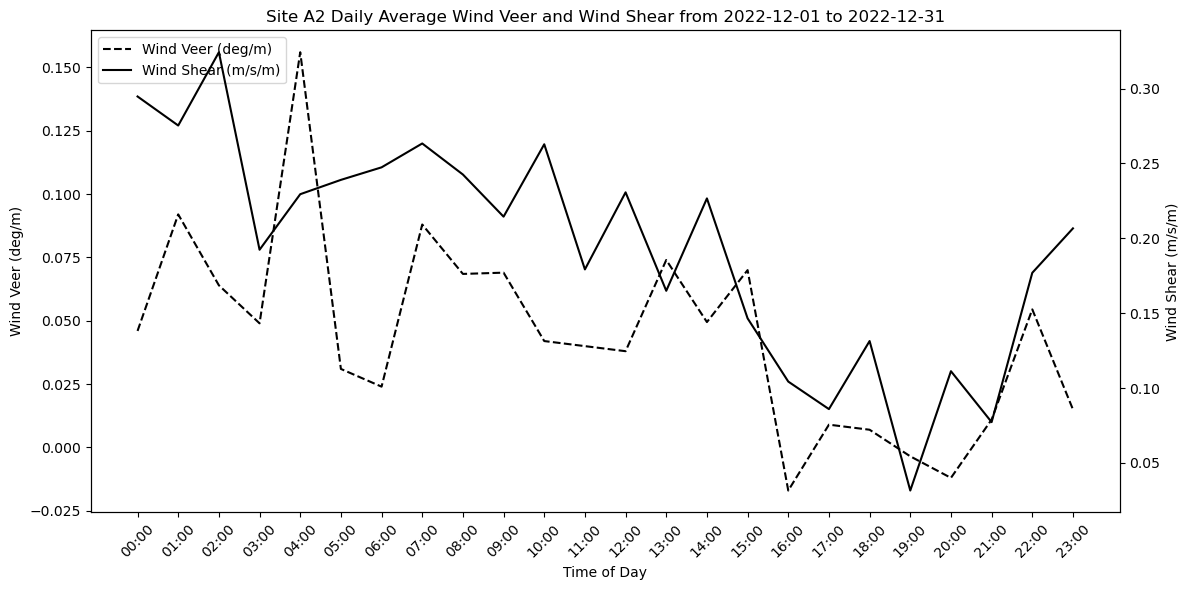


 JANUARY 2023
Start Date:  2023-01-01 00:00:00
End Date:  2023-01-31 00:00:00


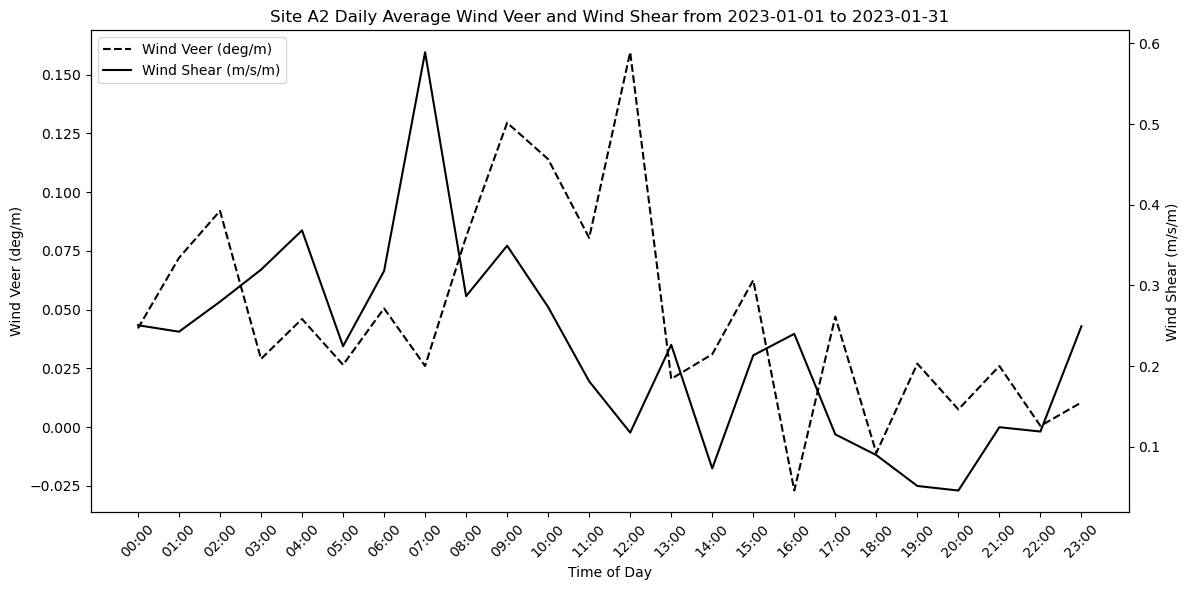


 FEBRUARY 2023
Start Date:  2023-02-01 00:00:00
End Date:  2023-02-28 00:00:00


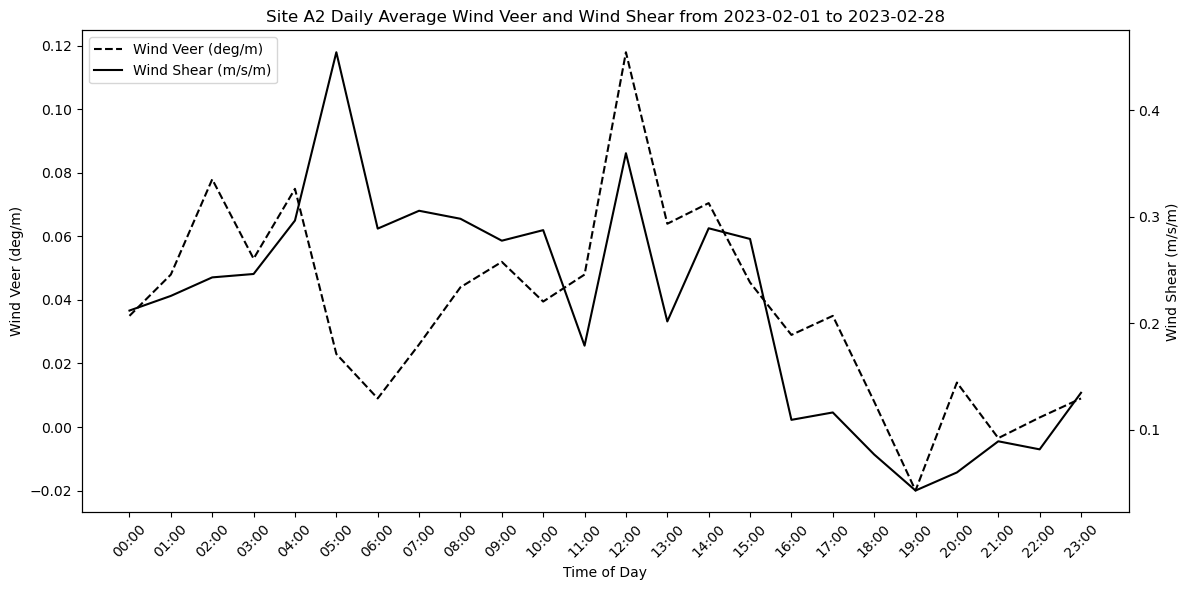


 MARCH 2023
Start Date:  2023-03-01 00:00:00
End Date:  2023-03-31 00:00:00


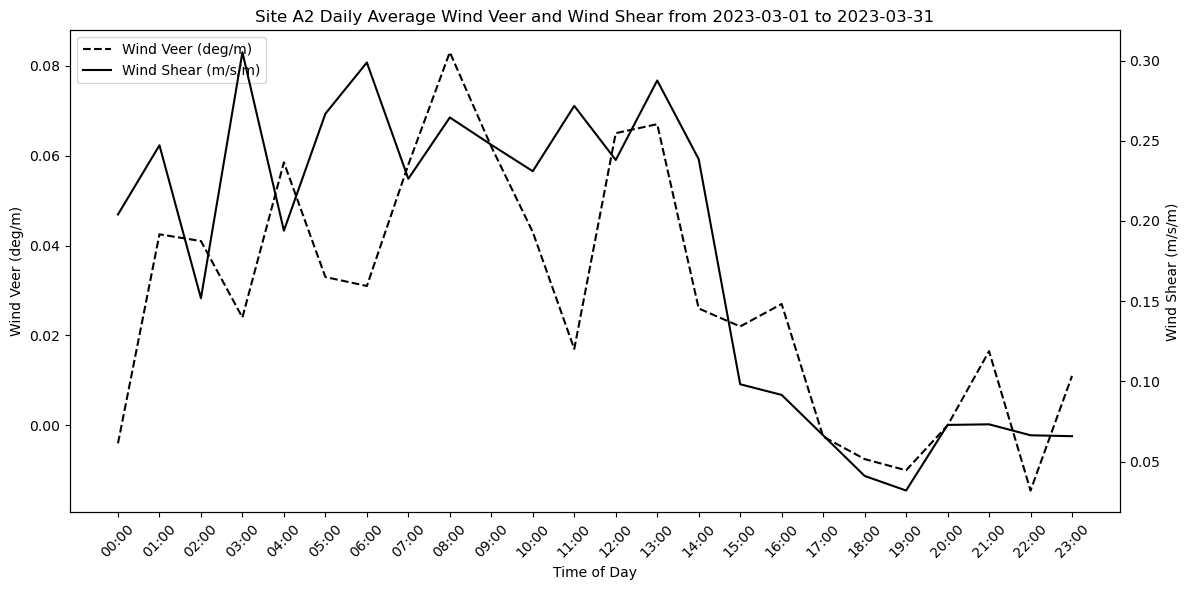


 APRIL 2023
Start Date:  2023-04-01 00:00:00
End Date:  2023-04-30 00:00:00


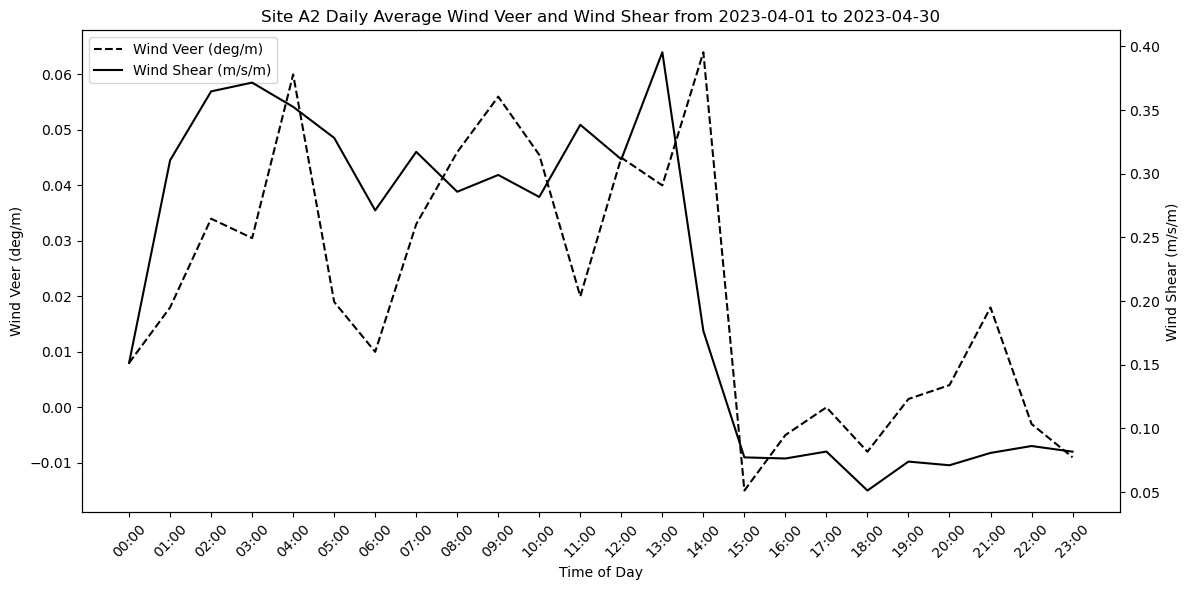


 MAY 2023
Start Date:  2023-05-01 00:00:00
End Date:  2023-05-31 00:00:00


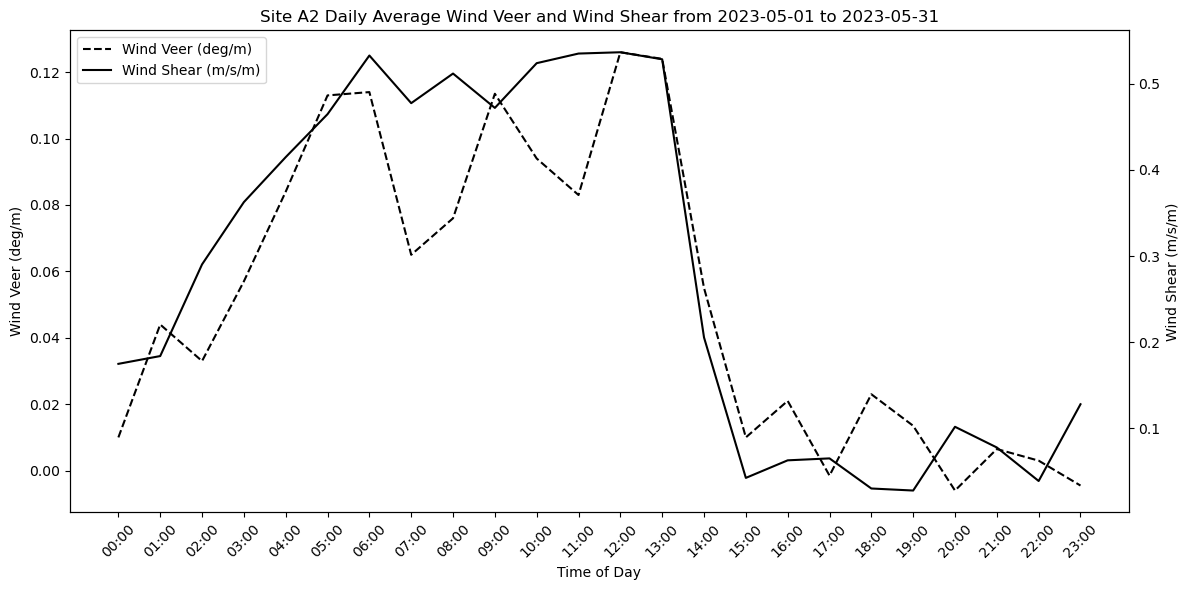


 JUNE 2023
Start Date:  2023-06-01 00:00:00
End Date:  2023-06-30 00:00:00


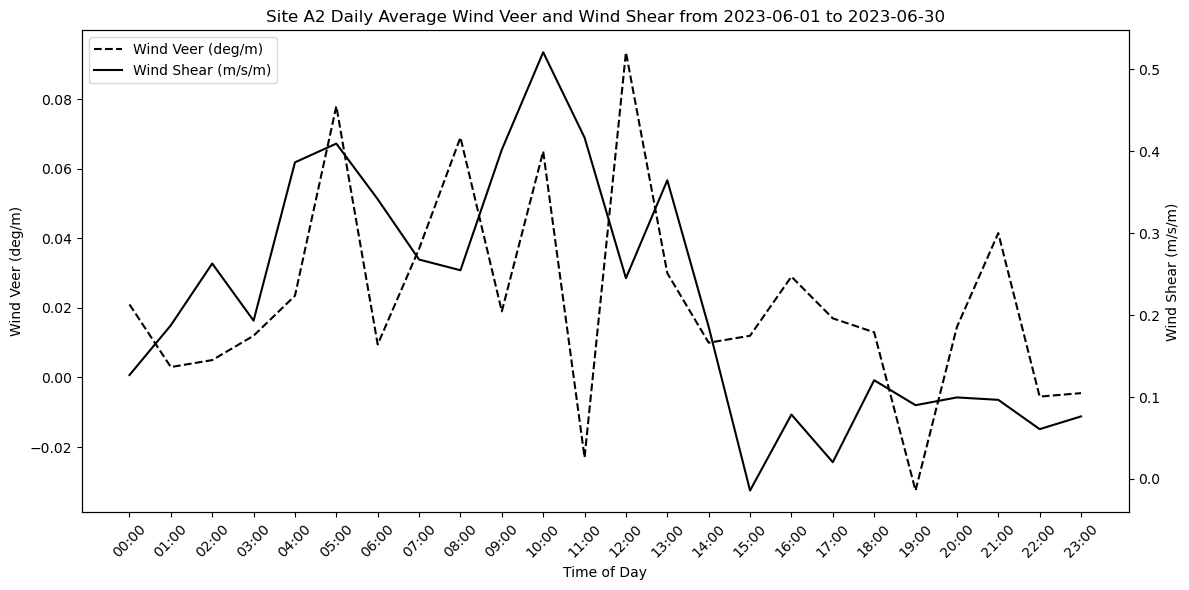


 JULY 2023
Start Date:  2023-07-01 00:00:00
End Date:  2023-07-31 00:00:00


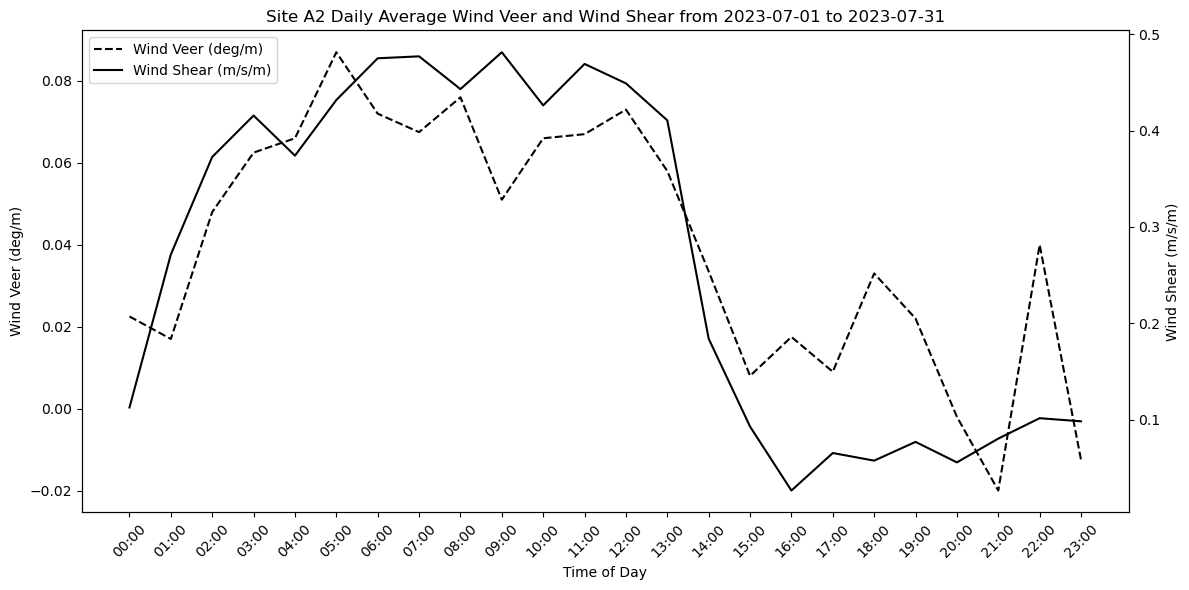


 AUGUST 2023
Start Date:  2023-08-01 00:00:00
End Date:  2023-08-31 00:00:00


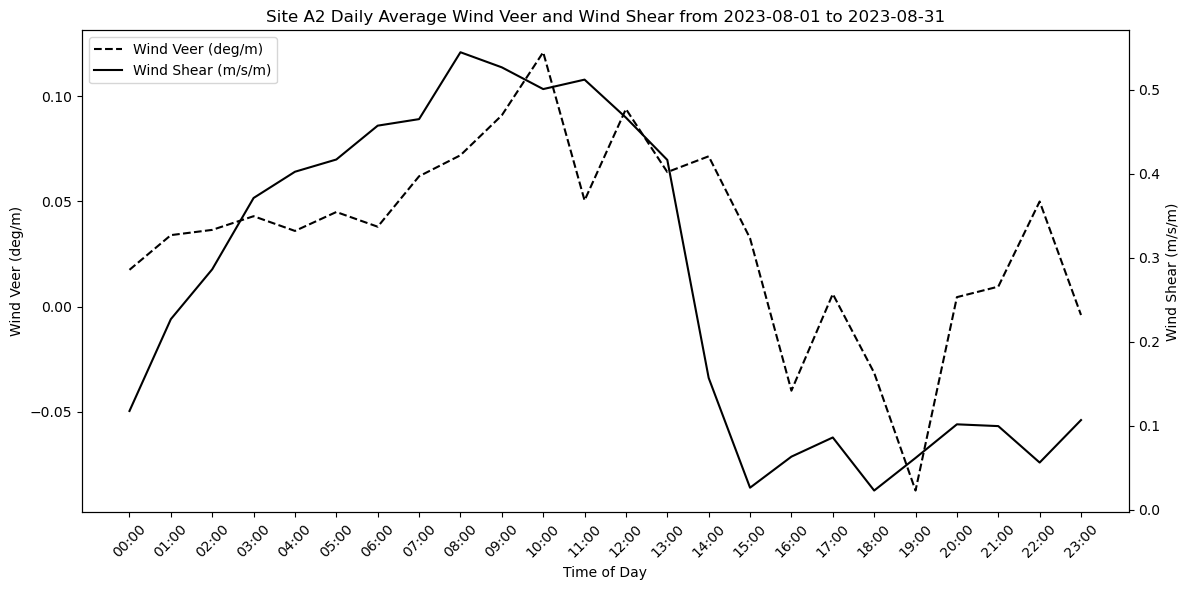


 SEPTEMBER 2023
Start Date:  2023-09-01 00:00:00
End Date:  2023-09-30 00:00:00


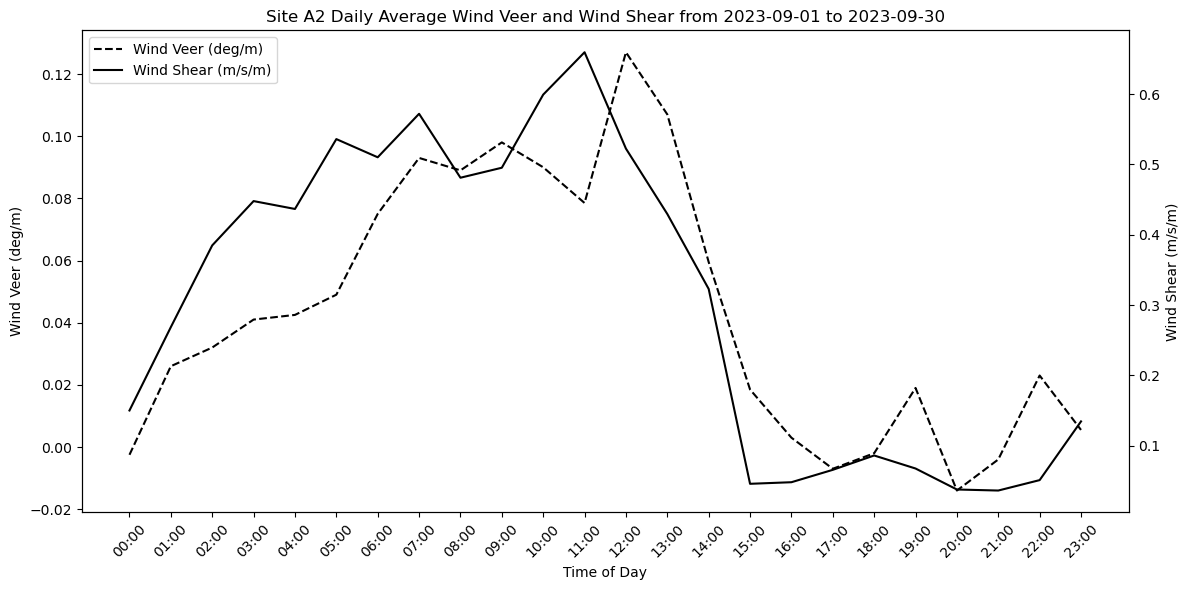


 OCTOBER 2023
Start Date:  2023-10-01 00:00:00
End Date:  2023-10-31 00:00:00


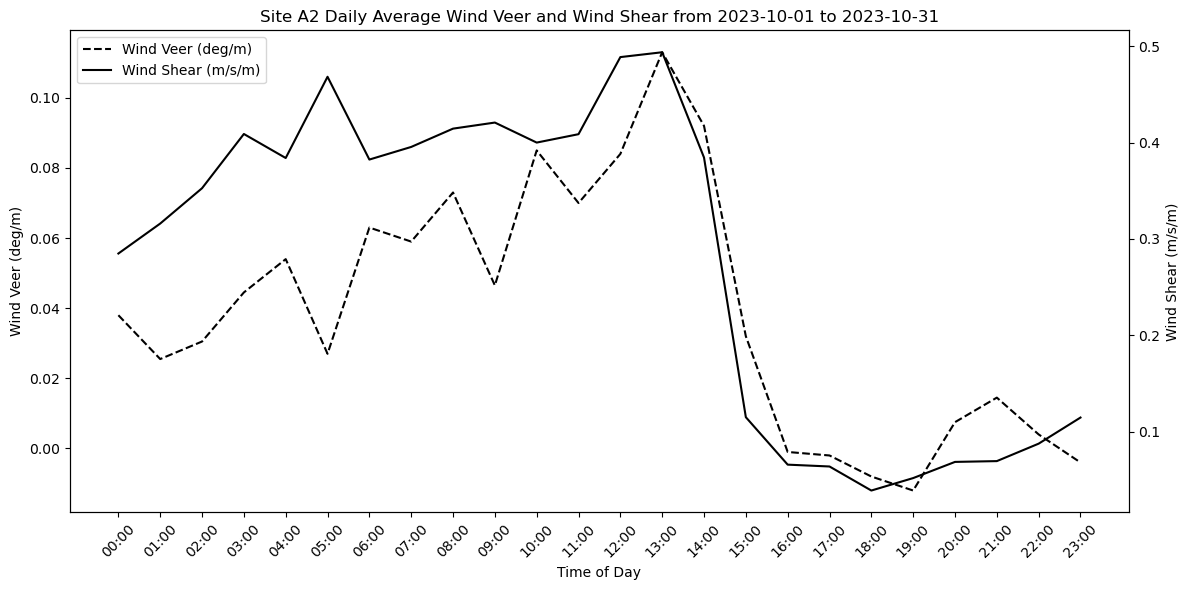


 NOVEMBER 2023
Start Date:  2023-11-01 00:00:00
End Date:  2023-11-06 00:00:00


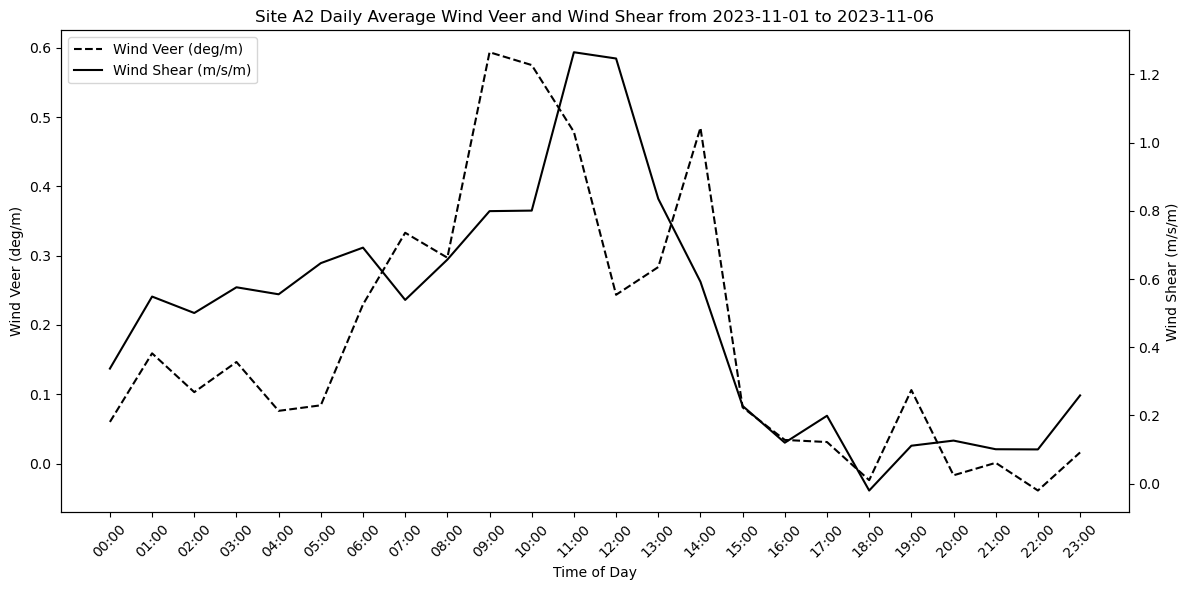

In [1419]:
print("A2 DAILY MONTHLY AVERAGES")
print("Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not")

#for 11-2022
print("\n", "NOVEMEBER 2022")
start_date = datetime(2022, 11, 11)
end_date = datetime(2022, 11, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 12-2022
print("\n", "DECEMBER 2022")
start_date = datetime(2022,12,1)
end_date = datetime(2022, 12, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 01-2023
print("\n", "JANUARY 2023")
start_date = datetime(2023,1,1)
end_date = datetime(2023, 1, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 02-2023
print("\n", "FEBRUARY 2023")
start_date = datetime(2023,2,1)
end_date = datetime(2023, 2, 28)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 03-2023
print("\n", "MARCH 2023")
start_date = datetime(2023,3,1)
end_date = datetime(2023, 3, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 04-2023
print("\n", "APRIL 2023")
start_date = datetime(2023,4,1)
end_date = datetime(2023, 4, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 05-2023
print("\n", "MAY 2023")
start_date = datetime(2023,5,1)
end_date = datetime(2023, 5, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 06-2023
print("\n", "JUNE 2023")
start_date = datetime(2023,6,1)
end_date = datetime(2023, 6, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 07-2023
print("\n", "JULY 2023")
start_date = datetime(2023,7,1)
end_date = datetime(2023, 7, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 08-2023
print("\n", "AUGUST 2023")
start_date = datetime(2023,8,1)
end_date = datetime(2023, 8, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 09-2023
print("\n", "SEPTEMBER 2023")
start_date = datetime(2023,9,1)
end_date = datetime(2023, 9, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 10-2023
print("\n", "OCTOBER 2023")
start_date = datetime(2023,10,1)
end_date = datetime(2023, 10, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 11-2023 (end date is later than A2 - can do full month)
print("\n", "NOVEMBER 2023")
start_date = datetime(2023,11,1)
end_date = datetime(2023, 11, 6)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)